# Basic Synthetic Data Generation with DeepBridge

This tutorial demonstrates how to generate synthetic data using the DeepBridge library. I'll walk you through creating synthetic datasets with different methods and comparing their results.

## Overview

In this demonstration, we'll:
1. Create a sample dataset with mixed data types
2. Generate synthetic versions using three different methods:
   - Gaussian Copula
   - CTGAN (Conditional Tabular GAN)
   - UltraLight Generator
3. Evaluate and compare the quality of each method
4. Visualize the differences between original and synthetic data

## Understanding the Different Methods

Each synthetic data generation method has its unique characteristics:

### Gaussian Copula
- Statistical method that preserves the marginal distributions and correlations between features
- Good balance between quality and computational efficiency
- Works well for numerical data with linear relationships
- Medium memory requirements

### CTGAN (Conditional Tabular GAN)
- Neural network-based approach using Generative Adversarial Networks
- Can capture complex, non-linear relationships in the data
- Highest quality for capturing complex patterns
- More computationally intensive and requires more memory
- Longer training time

### UltraLight Generator
- Simplest and fastest approach with minimal memory requirements
- Uses basic statistical modeling rather than complex ML models
- Excellent for large datasets or limited computational resources
- Quality may be lower for complex relationships

## Example Implementation

Let's look at the code to implement these methods:

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


import sys
import os

sys.path.append(os.path.expanduser("~/projetos/DeepBridge"))


from deepbridge.core.db_data import DBDataset
from deepbridge.synthetic import Synthesize


#---------------------------------------------------------
# Preparação de dados com cuidado especial 
#---------------------------------------------------------
print("Carregando e preparando dados...")

# Carregar dados
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Verificar e lidar com valores ausentes
print(f"Valores NaN em X antes da limpeza: {X.isna().sum().sum()}")
print(f"Valores infinitos em X: {np.isinf(X.values).sum()}")

# Resetar índices para garantir alinhamento limpo
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Resetar índices novamente após a divisão
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Criar DataFrames de treino e teste com nomes explícitos de colunas
train_df = X_train.copy()
train_df['target'] = y_train
test_df = X_test.copy()
test_df['target'] = y_test

# Verificação final
print(f"NaN em train_df: {train_df.isna().sum().sum()}")
print(f"NaN em test_df: {test_df.isna().sum().sum()}")

# Treinar modelo
print("\nTreinando modelo...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Criar objeto de dataset
print("\nCriando objeto de dataset...")
dataset = DBDataset(
    train_data=train_df,
    test_data=test_df,
    target_column='target',
    model=model
)



/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carregando e preparando dados...
Valores NaN em X antes da limpeza: 0
Valores infinitos em X: 0
NaN em train_df: 0
NaN em test_df: 0

Treinando modelo...

Criando objeto de dataset...


In [2]:
dataset

DBDataset(with 569 samples (not split))
Features: 30 total (0 categorical, 30 numerical)
Target: 'target'
Model: loaded
Predictions: available

Carregando dados e treinando modelo...
Acurácia no conjunto de teste: 0.9708

1. Teste de Robustez Básico
Baseline performance: {'accuracy': 0.9707602339181286, 'f1': 0.970603923775359}

Testando perturbação da feature: mean radius
Perturbation level 0.2: {'accuracy': 0.9707602339181286, 'f1': 0.970603923775359}
Resultados para perturbação de ruído (0.2): {'accuracy': 0.9707602339181286, 'f1': 0.970603923775359}

2. Tipos de Perturbação com RobustnessTester

2.1 Perturbação tipo 'noise' (ruído gaussiano)
Perturbation level 0.3: {'accuracy': 0.9707602339181286, 'f1': 0.970603923775359}
Desempenho após perturbação 'noise': {'accuracy': 0.9707602339181286, 'f1': 0.970603923775359}


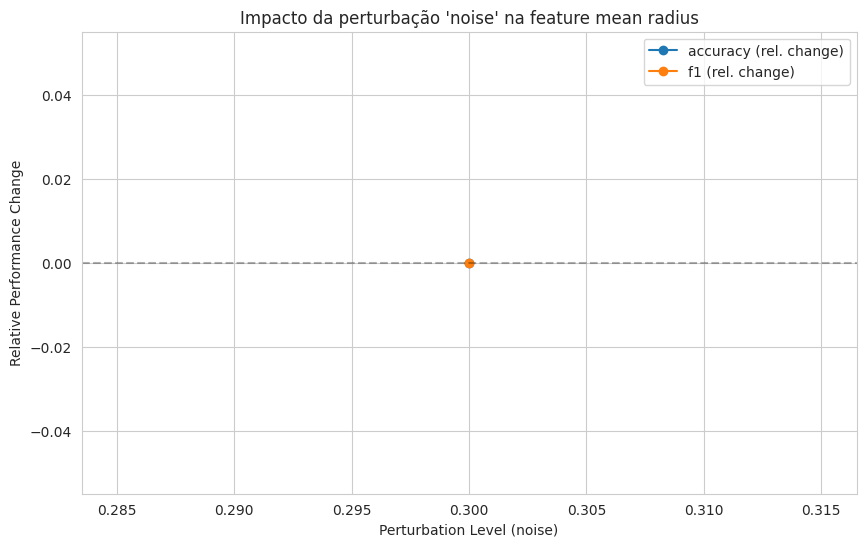


2.2 Perturbação tipo 'zero' (zerar valores)
Perturbation level 0.3: {'accuracy': 0.9707602339181286, 'f1': 0.970603923775359}
Desempenho após perturbação 'zero': {'accuracy': 0.9707602339181286, 'f1': 0.970603923775359}

2.3 Perturbação tipo 'flip' (inverter valores binários)
Nenhuma feature binária adequada encontrada para teste 'flip'

2.4 Perturbação tipo 'quantile' (mover para quantis)
Perturbation level 0.3: {'accuracy': 0.9707602339181286, 'f1': 0.970603923775359}
Desempenho após perturbação 'quantile': {'accuracy': 0.9707602339181286, 'f1': 0.970603923775359}

3. Funções Individuais de Perturbação

3.1 Ruído Gaussiano (apply_gaussian_noise)
Acurácia original: 0.9708
Acurácia após ruído gaussiano: 0.9591

3.2 Ruído Salt and Pepper (apply_salt_pepper_noise)
Acurácia após ruído salt and pepper: 0.9649

3.3 Perturbação de Feature Específica (apply_feature_perturbation)
Acurácia após perturbação de feature específica: 0.9708

4. Teste de Robustez contra Outliers
Baseline performance

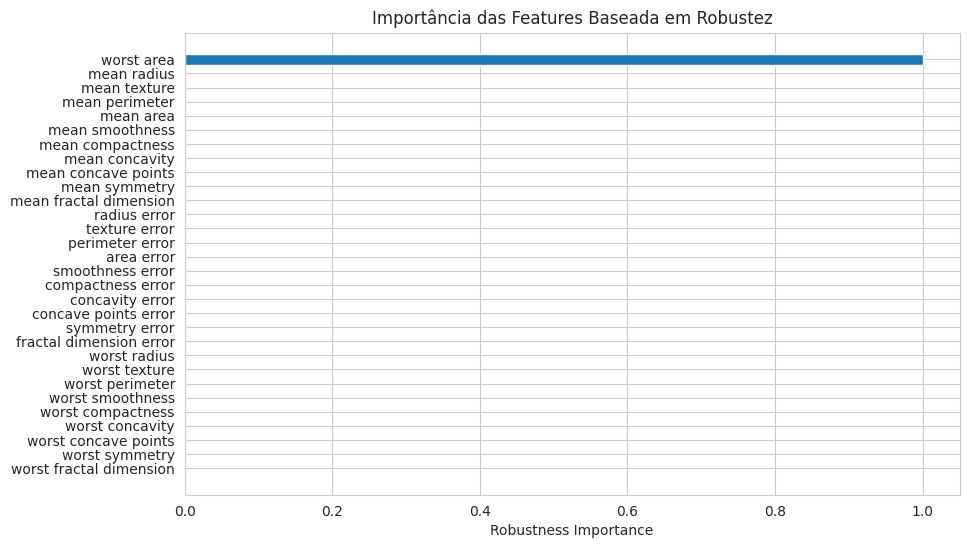


Demonstração completa de todos os tipos de perturbação!


In [16]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import warnings

# UserWarning vem do módulo warnings padrão do Python, não do sklearn
warnings.filterwarnings("ignore", category=UserWarning, 
                       message="X does not have valid feature names")

# Carregar dados e preparar o modelo
print("Carregando dados e treinando modelo...")
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print(f"Acurácia no conjunto de teste: {model.score(X_test, y_test):.4f}")

# Importações necessárias
from deepbridge.validation.frameworks.robustness.robustness_tester import RobustnessTester
from deepbridge.validation.frameworks.robustness.outlier_tester import OutlierRobustnessTester
from deepbridge.validation.frameworks.robustness.resilience_analyzer import ResilienceAnalyzer

from deepbridge.validation.frameworks.robustness.adversarial.fgsm_attack import generate_fgsm_attack
from deepbridge.validation.frameworks.robustness.adversarial.blackbox_attack import generate_blackbox_attack

from deepbridge.validation.frameworks.robustness.perturbation.gaussian_perturbation import apply_gaussian_noise
from deepbridge.validation.frameworks.robustness.perturbation.salt_pepper_perturbation import apply_salt_pepper_noise
from deepbridge.validation.frameworks.robustness.perturbation.quantile_perturbation import apply_feature_perturbation

# 1. Teste de Robustez Básico
print("\n1. Teste de Robustez Básico")
tester = RobustnessTester(
    model=model,
    X=X_test,
    y=y_test,
    problem_type='classification',
    verbose=True
)

# Testando perturbação em uma feature específica
feature_name = X_test.columns[0]  # Primeira feature
print(f"\nTestando perturbação da feature: {feature_name}")
result = tester.test_feature_perturbation(
    feature_name=feature_name, 
    perturbation_type='noise',  # tipo de perturbação
    perturbation_level=0.2      # nível de perturbação
)
print(f"Resultados para perturbação de ruído (0.2): {result['performance'][0]['metrics']}")

# 2. Demonstração de diferentes tipos de perturbação usando o RobustnessTester
print("\n2. Tipos de Perturbação com RobustnessTester")

# Perturbação tipo 'noise' (ruído gaussiano)
print("\n2.1 Perturbação tipo 'noise' (ruído gaussiano)")
noise_result = tester.test_feature_perturbation(
    feature_name=feature_name,
    perturbation_type='noise',
    perturbation_level=0.3
)
print(f"Desempenho após perturbação 'noise': {noise_result['performance'][0]['metrics']}")
# A visualização também é possível
fig = tester.plot_feature_perturbation(feature_name, 'noise')
plt.title(f"Impacto da perturbação 'noise' na feature {feature_name}")
plt.show()

# Perturbação tipo 'zero' (zerar valores)
print("\n2.2 Perturbação tipo 'zero' (zerar valores)")
zero_result = tester.test_feature_perturbation(
    feature_name=feature_name,
    perturbation_type='zero',
    perturbation_level=0.3
)
print(f"Desempenho após perturbação 'zero': {zero_result['performance'][0]['metrics']}")

# Perturbação tipo 'flip' (inverter valores binários)
print("\n2.3 Perturbação tipo 'flip' (inverter valores binários)")
# Encontrar uma feature binária ou categórica para demonstração
binary_features = [col for col in X_test.columns if len(X_test[col].unique()) <= 2]
if binary_features:
    binary_feature = binary_features[0]
    print(f"Usando feature binária: {binary_feature}")
    flip_result = tester.test_feature_perturbation(
        feature_name=binary_feature,
        perturbation_type='flip',
        perturbation_level=0.3
    )
    print(f"Desempenho após perturbação 'flip': {flip_result['performance'][0]['metrics']}")
else:
    print("Nenhuma feature binária adequada encontrada para teste 'flip'")

# Perturbação tipo 'quantile' (mover para quantis)
print("\n2.4 Perturbação tipo 'quantile' (mover para quantis)")
quantile_result = tester.test_feature_perturbation(
    feature_name=feature_name,
    perturbation_type='quantile',
    perturbation_level=0.3
)
print(f"Desempenho após perturbação 'quantile': {quantile_result['performance'][0]['metrics']}")

# 3. Demonstração de funções individuais de perturbação
print("\n3. Funções Individuais de Perturbação")

# Aplicar ruído gaussiano
print("\n3.1 Ruído Gaussiano (apply_gaussian_noise)")
X_noisy = apply_gaussian_noise(
    X=X_test,
    noise_level=0.2,         # Nível de ruído
    feature_wise=True,       # Aplicar ruído específico por feature
    seed=42                  # Semente para reprodutibilidade
)
noisy_score = model.score(X_noisy, y_test)
print(f"Acurácia original: {model.score(X_test, y_test):.4f}")
print(f"Acurácia após ruído gaussiano: {noisy_score:.4f}")

# Aplicar ruído salt and pepper
print("\n3.2 Ruído Salt and Pepper (apply_salt_pepper_noise)")
X_sp = apply_salt_pepper_noise(
    X=X_test,
    noise_ratio=0.1,         # Proporção de valores a perturbar
    salt_prob=0.5,           # Probabilidade de 'salt' vs 'pepper'
    seed=42
)
sp_score = model.score(X_sp, y_test)
print(f"Acurácia após ruído salt and pepper: {sp_score:.4f}")

# Aplicar perturbação de feature específica
print("\n3.3 Perturbação de Feature Específica (apply_feature_perturbation)")
X_perturbed = apply_feature_perturbation(
    X=X_test,
    feature_names=[feature_name],  # Lista de features para perturbar
    perturbation_type='quantile',  # Tipo de perturbação
    perturbation_level=0.2,        # Nível de perturbação
    seed=42
)
pert_score = model.score(X_perturbed, y_test)
print(f"Acurácia após perturbação de feature específica: {pert_score:.4f}")

# 4. Teste de Robustez contra Outliers
print("\n4. Teste de Robustez contra Outliers")
outlier_tester = OutlierRobustnessTester(
    model=model,
    X=X_test,
    y=y_test,
    outlier_detection_method='isolation_forest',  # Método de detecção de outliers
    verbose=True
)
outlier_results = outlier_tester.test_outlier_robustness(
    contamination=0.1  # Proporção esperada de outliers
)
print(f"Desempenho em inliers: {outlier_results['inlier_performance']}")
print(f"Desempenho em outliers: {outlier_results['outlier_performance']}")

# 5. Análise de Resiliência a Mudanças de Distribuição
print("\n5. Análise de Resiliência a Mudanças de Distribuição")
resilience_analyzer = ResilienceAnalyzer(
    model=model,
    X=X_test,
    y=y_test,
    verbose=True
)
# Testar resiliência a mudança de distribuição numa feature
shift_results = resilience_analyzer.test_distribution_shift(
    feature_name=feature_name,
    shift_type='mean',      # Tipo de mudança: 'mean', 'variance', 'skew'
    shift_levels=[0.1, 0.3, 0.5]  # Níveis de mudança
)
print(f"Resultados da mudança de distribuição: {shift_results['performance'][0]['metrics']}")

# 6. Ataques Adversariais
print("\n6. Ataques Adversariais")

try:
    # FGSM Attack (para modelos com gradientes)
    print("\n6.1 Ataque FGSM")
    # Para demonstração, precisaríamos de um modelo com gradientes (como uma rede neural)
    print("Nota: FGSM requer modelo com gradientes como PyTorch ou TensorFlow")
    
    # Blackbox Attack (para qualquer modelo)
    print("\n6.2 Ataque Blackbox")
    X_adv = generate_blackbox_attack(
        model=model,
        X=X_test,
        y=y_test,
        attack_type='random',  # Tipo de ataque: 'random' ou 'boundary'
        epsilon=0.1,           # Magnitude máxima de perturbação
        n_trials=10,           # Número de tentativas
        verbose=True
    )
    adv_score = model.score(X_adv, y_test)
    print(f"Acurácia após ataque adversarial: {adv_score:.4f}")
except Exception as e:
    print(f"Erro ao executar ataques adversariais: {str(e)}")

# 7. Teste com todas as features
print("\n7. Teste com Todas as Features")
all_results = tester.test_all_features(
    perturbation_type='noise',
    perturbation_level=0.2
)
# Exibir importância de features baseada em robustez
importance = all_results['feature_importance']
top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]
print("Features mais importantes baseadas em robustez:")
for feature, score in top_features:
    print(f"  {feature}: {score:.4f}")

# Visualização da importância das features
fig = tester.plot_feature_importance()
plt.title("Importância das Features Baseada em Robustez")
plt.show()

print("\nDemonstração completa de todos os tipos de perturbação!")

In [4]:
synthetic_df = Synthesize(
    dataset=dataset,
    method='gaussian',
    num_samples=1000,  
    verbose=False
)

/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45873 instead
  warnings.warn(
2025-03-25 08:19:39,713 - distributed.worker - ERROR - Compute Failed
Key:       _process_chunk_for_dask_standalone-934b037a-e997-4d7c-af59-306670a49709
State:     executing
Task:  <Task '_process_chunk_for_dask_standalone-934b037a-e997-4d7c-af59-306670a49709' apply(...)>
Exception: 'TypeError("unsupported operand type(s) for +: \'NoneType\' and \'int\'")'
Traceback: '  File "/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/dask/utils.py", line 77, in apply\n    return func(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^\n  File "/home/guhaase/projetos/DeepBridge/deepbridge/synthetic/methods/gaussian_copula.py", line 62, in _process_chunk_for_dask_standalone\n    np.random.seed(random_state + chunk_id)\n                   ~~


===== SYNTHETIC DATA QUALITY EVALUATION =====

OVERALL METRICS:
  - quality_score: 0.9598 (Excellent)
  - statistical_similarity: 0.9463 (Excellent)
  - privacy_score: 1.0000 (Excellent)
  - utility_score: 0.9463 (Excellent)

STATISTICAL METRICS:
  - avg_ks_statistic: 0.0561
  - avg_jensen_shannon_dist: 0.1563
  - correlation_mean_difference: 0.0512

PRIVACY METRICS:
  - Records at privacy risk: 0.00% (Low risk)
  - Average distance to nearest record: 2.8192

UTILITY METRICS:
  - distribution_similarity: 0.9439
  - correlation_preservation: 0.9488


Calculating similarity between original and synthetic data...
Inferred 30 numerical columns and 1 categorical columns
Using standard approach for similarity calculation
Similaridade média: 0.4715
Similaridade mínima: 0.0751
Similaridade máxima: 0.7542


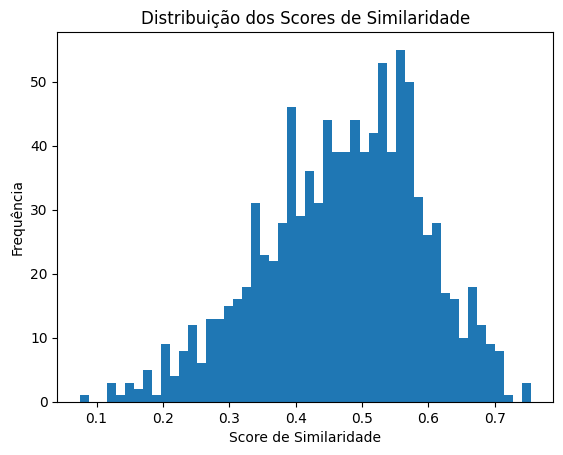

In [5]:
from deepbridge.synthetic.metrics.similarity import calculate_similarity

# Acesse os dados originais e os dados sintéticos
original_data = synthetic_df.original_data
synthetic_data = synthetic_df.data

# Calcule a similaridade
similarity_scores = calculate_similarity(
    original_data=original_data,
    synthetic_data=synthetic_data,
    # Parâmetros opcionais:
    metric='euclidean',         # Métrica de distância a ser usada
    n_neighbors=5,              # Número de vizinhos a considerar
    sample_size=10000,          # Tamanho máximo da amostra a usar
    random_state=42,            # Seed para reprodutibilidade
    verbose=True                # Mostrar informações de progresso
)

# similarity_scores é um pandas.Series com um score para cada amostra sintética
# Valores mais próximos de 1 indicam maior similaridade (mais parecidos)
# Valores mais próximos de 0 indicam menor similaridade (mais diferentes)

# Estatísticas de similaridade
print(f"Similaridade média: {similarity_scores.mean():.4f}")
print(f"Similaridade mínima: {similarity_scores.min():.4f}")
print(f"Similaridade máxima: {similarity_scores.max():.4f}")

# Você também pode visualizar a distribuição dos scores
import matplotlib.pyplot as plt
plt.hist(similarity_scores, bins=50)
plt.title('Distribuição dos Scores de Similaridade')
plt.xlabel('Score de Similaridade')
plt.ylabel('Frequência')
plt.show()

In [6]:
from deepbridge.synthetic.metrics.similarity import filter_by_similarity

# Filtra dados com similaridade acima de um limiar
filtered_data = filter_by_similarity(
    original_data=original_data,
    synthetic_data=synthetic_data,
    threshold=0.9,              # Remove samples com similaridade >= 0.9
    verbose=True
)

print(f"Amostras originais: {len(synthetic_data)}")
print(f"Amostras após filtragem: {len(filtered_data)}")

Filtering synthetic data with similarity threshold: 0.9
Inferred 30 numerical columns and 1 categorical columns
Calculating similarity between original and synthetic data...
Using standard approach for similarity calculation
Removed 0 samples (0.00%) with similarity ≥ 0.9
Amostras originais: 1000
Amostras após filtragem: 1000


In [7]:
# Avaliação da diversidade dos dados sintéticos
from deepbridge.synthetic.metrics.similarity import calculate_diversity

diversity_metrics = calculate_diversity(
    synthetic_data=synthetic_df.data,
    verbose=True
)

# Avaliação das diferenças de correlação entre variáveis numéricas
from deepbridge.synthetic.metrics.similarity import evaluate_pairwise_correlations

correlation_analysis = evaluate_pairwise_correlations(
    original_data=original_data,
    synthetic_data=synthetic_data
)

# Mostrar pares de colunas com maiores diferenças de correlação
print(correlation_analysis.head(10))

Calculating synthetic data diversity...
Diversity calculation complete
                  column1 column2  original_corr  synthetic_corr  difference  \
188        mean concavity  target      -0.696360       -0.424374   -0.271986   
436       worst perimeter  target      -0.782914       -0.518353   -0.264561   
419          worst radius  target      -0.776454       -0.516808   -0.259645   
458       worst concavity  target      -0.659610       -0.400891   -0.258719   
211   mean concave points  target      -0.776614       -0.528229   -0.248385   
461  worst concave points  target      -0.793566       -0.546539   -0.247027   
86         mean perimeter  target      -0.742636       -0.506927   -0.235708   
29            mean radius  target      -0.730029       -0.499423   -0.230606   
443            worst area  target      -0.733825       -0.505961   -0.227864   
113             mean area  target      -0.708984       -0.486764   -0.222219   

     abs_difference  is_significant  
188       

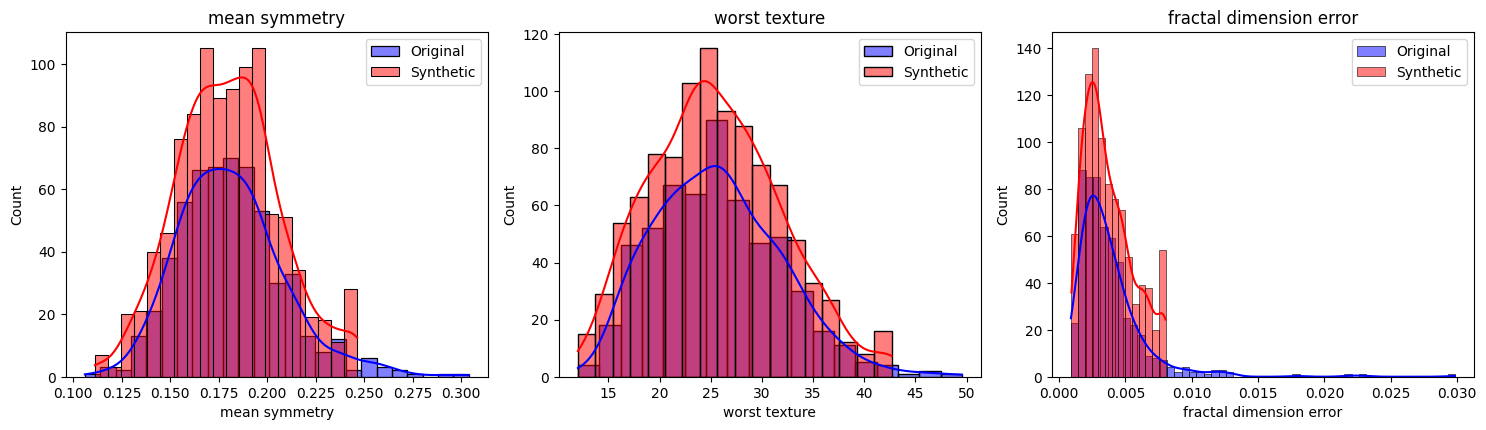

In [8]:
try:
    from deepbridge.synthetic.metrics.similarity import plot_distribution_comparison
    
    fig = plot_distribution_comparison(
        original_data=original_data,
        synthetic_data=synthetic_data
    )
    plt.show()
except ImportError:
    print("Módulo de visualização não disponível")

In [9]:
# Gerando um relatório HTML
report_path = synthetic_df.save_report("relatorio_dados_sinteticos.html")
print(f"Relatório gerado e salvo em: {report_path}")

Report saved to: relatorio_dados_sinteticos.html
Relatório gerado e salvo em: relatorio_dados_sinteticos.html


In [10]:
X = synthetic_df.data.drop('target', axis=1)
y = synthetic_df.data['target']

In [11]:
y_pred = model.predict(X)

In [12]:
# # 6. Avaliação do modelo
# accuracy = accuracy_score(y, y_pred)
# report = classification_report(y, y_pred)

# print(report)

In [13]:
# Importações adicionais para a nova estrutura refatorada
from deepbridge.validation.model_types.classification.robustness import ClassificationRobustness


# Usando o objeto dataset e modelo que você já criou
robustness_tester = ClassificationRobustness(dataset=dataset, model=model)

# Opção 1: Teste específico de robustez (por exemplo, ruído gaussiano)
gaussian_results = robustness_tester.evaluate_gaussian_noise_robustness(
    noise_levels=[0.01, 0.05, 0.1, 0.2],
    metrics=['accuracy', 'f1', 'auc'],
    n_iterations=5,
    test_set=True  # Usar conjunto de teste
)

ImportError: cannot import name 'ClassificationRobustnessTests' from 'deepbridge.validation.model_types.classification' (/home/guhaase/projetos/DeepBridge/deepbridge/validation/model_types/classification/__init__.py)

In [ ]:
from deepbridge.validation import Validator

# Usar o Validator integrado
robustness_validator = Validator(dataset, "robustness")
results = robustness_validator.evaluate_model_robustness(
    perturb_method='raw',
    perturb_sizes=[0.01, 0.05, 0.1, 0.2]
)

# Visualizar resultados
robustness_validator.visualize_results(result_type='robustness')

# Ou gerar um relatório
report = robustness_validator.generate_validation_report(output_format='markdown')
print(report)